### Setup

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Final_Project")

In [ ]:
os.listdir()

['notebooks',
 'template.gslides',
 '2021_Савченко Андрей_Распознавание вовлеченности участника онлайн-мероприятия на основе анализа видеоизображений лиц.gslides',
 'data',
 'models',
 'Engagement_Labels_Engagement.xlsx']

In [ ]:
import cv2
import glob

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from google.colab.patches import cv2_imshow

import torch
from torch.utils.data import Dataset, DataLoader

### Dataset

In [ ]:
train_frames_dir = "data/frames/train/"
val_frames_dir = "data/frames/validation/"

print(len(os.listdir(train_frames_dir)))
print(len(os.listdir(val_frames_dir)))

84
21


In [ ]:
path_to_csv = "data/engagement_labels.csv"

In [ ]:
from torchvision import transforms
import torchvision.transforms.functional as TF

In [ ]:
def read_bbox_file(path):
    with open(path, "r") as f:
        bbox = f.read()
  
    return [int(b) for b in bbox.split()]

class EngagementDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.video_labels = dict(pd.read_csv(csv_file).values)
        self.root_dir = root_dir
        self.transform = transform

        self.frame_paths, self.labels = self.get_data()
        self.bboxes = [read_bbox_file(self.frame_paths[0].replace('.jpg', '.txt'))]

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        frame_path = self.frame_paths[idx]
        bbox_path = frame_path.replace(".jpg", ".txt")
        label = float(self.labels[idx])

        frame_image = cv2.imread(frame_path)
        x1, y1, x2, y2 = read_bbox_file(bbox_path) #self.bboxes[idx]

        extra_margin = 10
        face = frame_image[max(0, y1 - extra_margin):y2 + extra_margin, max(0, x1 - extra_margin):x2 + extra_margin]  # using this because original crops seem to be small
        
        sample = {'face': face, 'label': label}
        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_data(self):
        frame_paths, labels, bboxes = [], [], []

        for video_folder in tqdm(sorted(os.listdir(self.root_dir)), desc="Collecting paths"):
            label = self.video_labels.get(video_folder, None)
            if not label:
                continue
            float_label = float(label.replace(",", "."))

            bbox_paths = glob.glob(os.path.join(self.root_dir, video_folder, "*.txt"))
            f_paths = [p.replace(".txt", ".jpg") for p in bbox_paths]  # there are some missing bboxes, so we pick those with bboxes

            frame_paths += f_paths
            labels += [float_label] * len(f_paths)
            # bboxes += [read_bbox_file(bbox_path) for bbox_path in bbox_paths]

        assert len(frame_paths) == len(labels)

        return frame_paths, labels #, bboxes

In [ ]:
resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor()
])
def preprocess(sample, transform=resize):
    sample['face'] = transform(sample['face'])
    return sample

In [ ]:
# class FastAndBigDataset(Dataset):
#     def __init__(self, engagement_dataset):
#         self.pics = []
#         self.labels = []
#         for i in tqdm(range(len(engagement_dataset))):
#             sample = engagement_dataset[i]
#             self.pics.append(sample['face'])
#             self.labels.append(sample['label'])

#     def __len__(self):
#         return len(self.pics)

#     def __getitem__(self, idx):
#       return self.pics[idx], self.labels[idx]

In [ ]:
train_dataset = EngagementDataset(csv_file=path_to_csv, root_dir=train_frames_dir, transform=preprocess)
# train_fast_dataset = FastAndBigDataset(train_dataset)

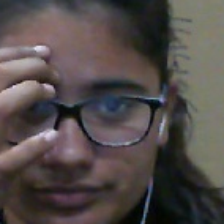

0.66


In [ ]:
sample = train_dataset[50]
cv2_imshow((sample["face"].permute(1, 2, 0).numpy()*255))
print(sample["label"])

In [ ]:
val_dataset = EngagementDataset(csv_file=path_to_csv, root_dir=val_frames_dir, transform=preprocess)

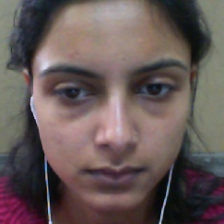

0.33


In [ ]:
i = np.random.randint(0, len(val_dataset))
sample = val_dataset[i]
cv2_imshow((sample["face"].permute(1, 2, 0).numpy()*255))
print(sample["label"])

In [ ]:
import pickle

In [ ]:
train_bb = []
for i in tqdm(range(len(train_dataset))):
    train_bb.append(read_bbox_file(train_dataset.frame_paths[i].replace('.jpg', '.txt')))

  0%|          | 0/51436 [00:00<?, ?it/s]

In [ ]:
pickle.dump(train_bb, open('data/train_bb.pkl', 'wb'))

In [ ]:
val_bb = []
for i in tqdm(range(len(val_dataset))):
    val_bb.append(read_bbox_file(val_dataset.frame_paths[i].replace('.jpg', '.txt')))

  0%|          | 0/18791 [00:00<?, ?it/s]

In [ ]:
pickle.dump(val_bb, open('data/val_bb.pkl', 'wb'))